$\, \text{\textbf{Python Session 2}} \, $

Through this Python session, we aim at numerically solving the following $\, \textcolor{blue}{\text{non-linear}} \, $ System Identification (SI) problem:
$$
\text{SI} \quad \begin{cases}
\displaystyle \underset{w \in \mathbb{R}^m}{\min} \quad \sum^N_{i=1} \frac{1}{2} \| x_{w,t^i_0,x^i_0}(t^i_1) - x^i_1 \|^2 , \\[2.5px]
\text{where} \ \ x_{w,t_0,x_0}(\cdot) \ \ \text{denotes the unique solution to} \ \ \begin{cases}
\dot{x}(t) = f_w(x(t)) \\
x(t_0) = x_0 .
\end{cases}
\end{cases}
$$
Specifically, we assume we are provided with a set of $\ N \ $ data points $\ \mathcal{D} = \{ (t^i_0,x^i_0,t^i_1,x^i_1) \}_{i=1,\dots,N} \ $ that represent input-output realizations of some non-linear system (dynamics) $\ f : \mathbb{R}^n \to \mathbb{R}^n \ $, that is $\ x^i_1 = x_{t^i_0,x^i_0}(t^i_1) \ $ with $\ x_{t_0,x_0}(\cdot) \ $ the unique solution to $\ \begin{cases}
\dot{x}(t) = f(x(t)) \\
x(t_0) = x_0
\end{cases} . \ $ By solving SI, the objective consists of identifying, or learning, $\ f \ $ through a Neural Network (NN) $\ w \mapsto f_w \ $ by accurately "matching" its flow with $\ f$'s along the data set $\ \mathcal{D} \ $. This method is known as $\, \text{\textbf{NeuralODE}} \, $.

SI very closely resembles an optimal control problem, with two main differences. First, the optimization is performed over finite-dimensional parameters $\ w \in \mathbb{R}^m \ $ instead than infinite-dimensional controls. Second, the optimization is performed integrating the dynamics over several initial conditions instead than just one condition.

We will solve SI through the $\, \text{\textbf{Stochastic Gradient Descent (SGD)}} \, $ method. Specifically, let us denote $\ L_i(w) \triangleq \frac{1}{2} \| x_{w,t^i_0,x^i_0}(t^i_1) - x^i_1 \|^2 \ $ (the letter $L$ stands for "loss", a commonly used term in the learning community to denote costs). Since SI can be reformulated as $\ \underset{w \in \mathbb{R}^m}{\min} \ \sum^N_{i=1} L_i(w) , \ $ minima $w^* \in \mathbb{R}^m$ to SI must satisfy $\ \sum^N_{i=1} \nabla_w L_i(w^*) = 0 \ $ and therefore they can be sought iteratively through the rule $\ w_{k+1} = w_k - h \sum^N_{i=1} \nabla_w L_i(w_k) , \ $ for some stepsize $\ h > 0 . \ $ Since $N$ is generally very large, computing $\ \nabla_w L_i(w_k) \ $ at each iteration $\ k \in \mathbb{N} \ $ for all $\ i=1,\dots,N \ $ is generally very expensive. The SGD method efficiently mitigates this bottleneck by computing $\ \nabla_w L_i(w_k) \ $ at each iteration $\ k \in \mathbb{N} \ $ for a smaller amount of $\ i \in 1,\dots,N \ $. In particular, at each $\ k \in \mathbb{N} \ $ a $\, \text{\textbf{mini batch}} \, $ $\mathcal{B}_k \subseteq \{ 1,\dots,N \} \ $, which is made of a considerably smaller amount of data, is selected randomly and the previous rule is replaced with the following
$$
\text{SGD} \quad w_{k+1} = w_k - h \sum_{j \in \mathcal{B}_k} \nabla_w L_j(w_k)
$$
Besides improving computational efficiency, SGD has been observed to more often find "better" minima.

To practically implement NeuralODE, it remains to more explicitly compute $\ L_i(w) \ $, for any fixed $\ i \in 1,\dots,N \ $. This computation is achieved in three steps:
1. Given $\ w \in \mathbb{R}^m \ $ and $\ (t^i_0,x^i_0) , \ $ numerically compute $\ x_{w,t^i_0,x^i_0}(\cdot) \ $ the unique solution to $\ \begin{cases}
\dot{x}(t) = f_w(x(t)) \\
x(t^i_0) = x^i_0
\end{cases} , \ $ e.g., through explicit Euler integration schemes.
2. Given $\ (t^i_1,x^i_1) , \ $ numerically compute $\ p_{w,t^i_0,x^i_0,t^i_1,x^i_1}(\cdot) \ $ the unique solution to
   $$
   \begin{cases}
   \displaystyle \dot{p}(t) = -\left( \frac{\partial f_w}{\partial x} \right)^{\top}(x_{w,t^i_0,x^i_0}(t)) \ \ p(t) \\
   p(t^i_1) = x_{w,t^i_0,x^i_0}(t^i_1) - x^i_1
   \end{cases} ,
   $$
   e.g., through explicit Euler integration schemes. Note that the above differential equation $\, \text{\textbf{must be integrated backward in time!}} \, $
4. Through the theory of optimal control we got acquainted wth during this course, it can be showed that we must return, e.g., through explicit Euler integration,
   $$
   \nabla_w L_i(w) = \int^{t^i_1}_{t^i_0} \left( \frac{\partial f_w}{\partial u} \right)^{\top}(x_{w,t^i_0,x^i_0}(t)) \ \ p(t) \; \mathrm{d}t \ .
   $$

Please, populate the Python code below to solve SI. $\, \textcolor{blue}{\text{You will test and analyize the performance of your code on the simple example at the end of the script.}} \, $

$\, \textcolor{red}{\text{\textbf{Possible directions to investigate to enrich your group evaluating presentation, from easier (less points) to tougher (more points)}}} \, $

1. Correctly complete all of this Pyhton session's scripts.
2. Going beyond visual comparisons between $\ f \ $ and $\ f_w$'s flows, find a more principled strategy to compute the error between the true dynamics and the learned one.
3. Reproduce and analyze all the results presented during this Python session on more challenging and realistic $\, \textcolor{blue}{\text{non-linear}} \, $ $f$, obtaining correct error comparisons.

In [142]:
# Basic learning tools

import autograd.numpy as np
from autograd import jacobian, grad
from autograd.misc.flatten import flatten
import random
import scipy.integrate
odeint = scipy.integrate.odeint
import matplotlib.pyplot as plt
import time

In [144]:
# Neural network definition
# We model the mapping weights -> f_weights as a fully connected NN
# Specifically, input and output layers are of dimension dim = n, whereas
# there are as much hidden layers as we wish of arbitrary dimension
# Denoting weights = (w,b), each inner layer follows the rule
# x_k+1 = tanh(w_k+1 * x_k + b_k+1), with tanh as activation function, whereas
# the output layer follows the linear transformation x_out = w_out * x_out-1 + b_out

# Randomly initialize the weights of the neural network
# Input and output layers are of dimension dim, whreas we take, for instance,
# two hidden layers with 32 neurons each (you can change that at your will!)
def NeuralNetworkInitialization(dim, hiddenLayers=[32, 32]):

    # Input -> Hidden layers -> Output
    layers = [dim] + hiddenLayers + [dim]
    weights = []
    for i in range(len(layers) - 1):
        w = np.random.normal(0, 0.1, (layers[i + 1], layers[i]))  # Layer weights
        b = np.random.normal(0, 0.1, (layers[i + 1]))  # Biases
        weights.append((w, b))
    
    # Flatten weights into a single vector
    flatWeights, unflatten = flatten(weights)
    
    return flatWeights, unflatten

# Compute x -> f_weights(x)
def NeuralNetwork(x, flatWeights, unflatten):
    
    # Convert flat weights back to structured form
    weights = unflatten(flatWeights)
    
    for w, b in weights[:-1]:  # Hidden layers with tanh activation
        x = # COMPLETE THE CODE
    w_out, b_out = weights[-1]  # Output layer (linear transformation)
    
    return # COMPLETE THE CODE

In [146]:
# Compute gradient of the loss w.r.t weights

# The following function must return (x,p) as solutions to steps 1. and 2. above
# Recall that fw = NN !!!
def coupledDynamics(dim, Nint, t0, x0, t1, x1, flatWeights, NeuralNetwork, unflatten):

    # Integrate the forward state equation via Euler explicit schemes
    dt = (t1 - t0) / (Nint - 1)
    x = np.zeros((dim, Nint))
    x[:,0] = x0
    for i in range(Nint - 1):
        x[:,i+1] = # COMPLETE THE CODE

    # Integrate the backward adjoint equation via Euler explicit schemes
    # Recall that you must integrate backward in time!!!
    p = np.zeros((dim, Nint))
    p[:,-1] = # COMPLETE THE CODE
    for i in range(Nint - 1):
        df_dx_t1_minus_i = jacobian(NeuralNetwork, 0)(x[:,# COMPLETE THE CODE
                                                      ], flatWeights, unflatten)
        p[:,# COMPLETE THE CODE
        ] = # COMPLETE THE CODE

    return x, p

# The following function must return gradient of the loss w.r.t weights as in step 3. above
def gradLoss_oneX0(dim, Nint, t0, x0, t1, x1, flatWeights, NeuralNetwork, unflatten):

    # Compute the curves-in-time (x,p) through the previous function
    x, p = # COMPLETE THE CODE
    
    # We additionally store the loss itself to chck improvements along SGD iterations
    loss = # COMPLETE THE CODE

    # Compute the integral as in step 3. above via Euler explicit integration
    dt = (t1 - t0) / (Nint - 1)
    gradLoss = np.zeros_like(flatWeights)  # Ensure correct shape
    for i in range(Nint - 1):
        df_dw_i = jacobian(NeuralNetwork, 1)(x[:, i], flatWeights, unflatten)
        gradLoss += # COMPLETE THE CODE

    return loss, gradLoss

In [148]:
# Stochastic Gradient Descent
# We implement the SGD method as previously explained
# To modify mini-batch of data through SGD iterations, use the
# Python function batch = random.sample(data, batchSize)

def gradientDescent(dim, Nint, t0s, x0s, t1s, x1s, flatWeights, NeuralNetwork, unflatten, 
                    batchSize, h=1e-2, steps=500):

    # Store loss for plotting and organize data in an ordered list
    lossHistory = []
    data = list(zip(t0s, x0s, t1s, x1s))

    # SDG iterations
    for i in range(steps + 1):

        # Random mini-batch selection
        batch = random.sample(data, batchSize)

        # Compute mini-batch gradient
        batchGrad = np.zeros_like(flatWeights)
        for t0, x0, t1, x1 in batch:
            loss, gradLoss = # COMPLETE THE CODE
            batchGrad += # COMPLETE THE CODE  # Accumulate gradients

        # Update weights using the mini-batch gradient
        flatWeights -= # COMPLETE THE CODE

        # Periodically compute the loss on the full dataset
        if i % 20 == 0 or i == steps:
            totalLoss = sum(# COMPLETE THE CODE 
                            for t0, x0, t1, x1 in data)
            lossHistory.append(totalLoss)
            print(f"Iter = {i:3d} / {steps:3d} ,     Loss = {totalLoss:.8f}")

    return flatWeights, lossHistory

In [190]:
# Example
# We aim at learning the asymptotically stable dynamics
# x in R^2 -> ( (-0.1 , -1.0) , (0.1 , -1.0) ) x in R^2

# Dynamics to learn
dimEx = 2
def linear_dynamics(z, t):
    A = # COMPLETE THE CODE
    return A @ z

# Initialize with successive realizations of the dynamics
Ndata = 20  # Number of random data points
Nbatch = 5  # Number of random data points in the batch
np.random.seed(0)  # Fix randomness for reproducibility
x0random = np.random.normal(0, 0.5, (1, 2))  # One random initial point
x0s = np.zeros((Ndata,dimEx))
x1s = np.zeros((Ndata,dimEx))

# Define a function to forward integrate data initial conditions
def forward(dim, Nint, t0, x0, t1, dynamics):
    dt = (t1 - t0) / (Nint - 1)
    x = np.zeros((dim,Nint))
    x[:,0] = x0
    for i in range(Nint - 1):
        x[:,i+1] = # COMPLETE THE CODE
    return x[:,-1]

# Produce data
t0, t1, NintEx = 0, 1, 50
x0s[0,:] = x0random
for i in range(Ndata - 1):
    x1s[i,:] = forward(# COMPLETE THE CODE
                       )
    x0s[i+1:] = # COMPLETE THE CODE
x1s[Ndata-1,:] = forward(# COMPLETE THE CODE
                         )

# Learn the model
flatWeights, unflatten = NeuralNetworkInitialization(dimEx)  # Neural network initialization
flatWeights, lossHistory = gradientDescent(dimEx, NintEx,
                                           np.full(Ndata, t0), x0s, np.full(Ndata, t1), x1s,
                                           flatWeights, NeuralNetwork, unflatten,
                                           Nbatch, h=1e-2, steps=600)

Iter =   0 / 600 ,     Loss = 2.13507947
Iter =  20 / 600 ,     Loss = 1.92095456
Iter =  40 / 600 ,     Loss = 1.76439556
Iter =  60 / 600 ,     Loss = 1.64371644
Iter =  80 / 600 ,     Loss = 1.51750182
Iter = 100 / 600 ,     Loss = 1.40498426
Iter = 120 / 600 ,     Loss = 1.24175021
Iter = 140 / 600 ,     Loss = 1.07805597
Iter = 160 / 600 ,     Loss = 0.94097963
Iter = 180 / 600 ,     Loss = 0.80601384
Iter = 200 / 600 ,     Loss = 0.66297706
Iter = 220 / 600 ,     Loss = 0.52696628
Iter = 240 / 600 ,     Loss = 0.40698648
Iter = 260 / 600 ,     Loss = 0.32074051
Iter = 280 / 600 ,     Loss = 0.23787603
Iter = 300 / 600 ,     Loss = 0.16413318
Iter = 320 / 600 ,     Loss = 0.11003948
Iter = 340 / 600 ,     Loss = 0.07820198
Iter = 360 / 600 ,     Loss = 0.04812162
Iter = 380 / 600 ,     Loss = 0.03397122
Iter = 400 / 600 ,     Loss = 0.02285489
Iter = 420 / 600 ,     Loss = 0.01530423
Iter = 440 / 600 ,     Loss = 0.00928730
Iter = 460 / 600 ,     Loss = 0.00554347
Iter = 480 / 600

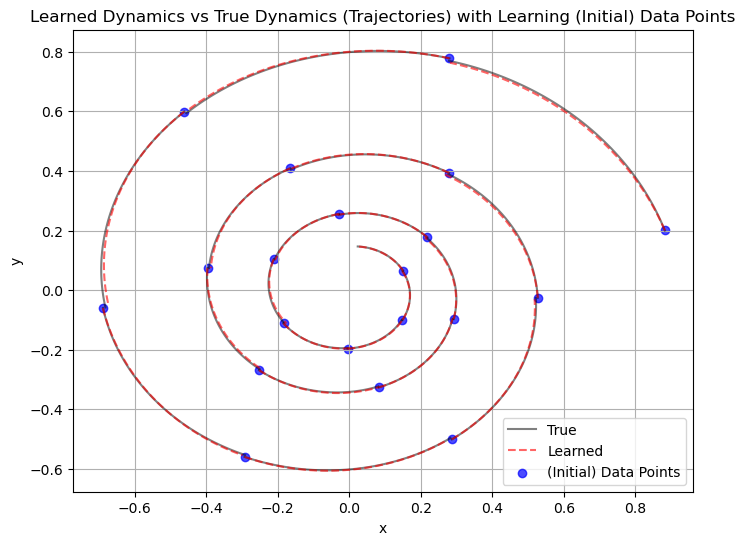

In [191]:
# Plotting
# Test fidelity over data points

# Define time range for visualization
t_eval = np.linspace(t0, t1, 100)  # 100 time steps

# Generate true trajectories
true_trajectories = np.array([odeint(linear_dynamics, x0, t_eval) for x0 in x0s])

# Generate trajectories via the learned model
learned_trajectories = np.array([
    odeint(lambda x, t: NeuralNetwork(x, flatWeights, unflatten), x0, t_eval) for x0 in x0s])

# Plot results
plt.figure(figsize=(8, 6))

# Plot the true and learned trajectories
for i in range(len(x0s)):
    plt.plot(true_trajectories[i, :, 0], true_trajectories[i, :, 1], 'k-', alpha=0.5, label="True" if i == 0 else "")
    plt.plot(learned_trajectories[i, :, 0], learned_trajectories[i, :, 1], 'r--', alpha=0.6, label="Learned" if i == 0 else "")

# Scatter plot for the initial data points (learning data points)
plt.scatter(x0s[:, 0], x0s[:, 1], color='blue', marker='o', alpha=0.7, label="(Initial) Data Points")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Learned Dynamics vs True Dynamics (Trajectories) with Learning (Initial) Data Points")
plt.legend()
plt.grid()
plt.show()

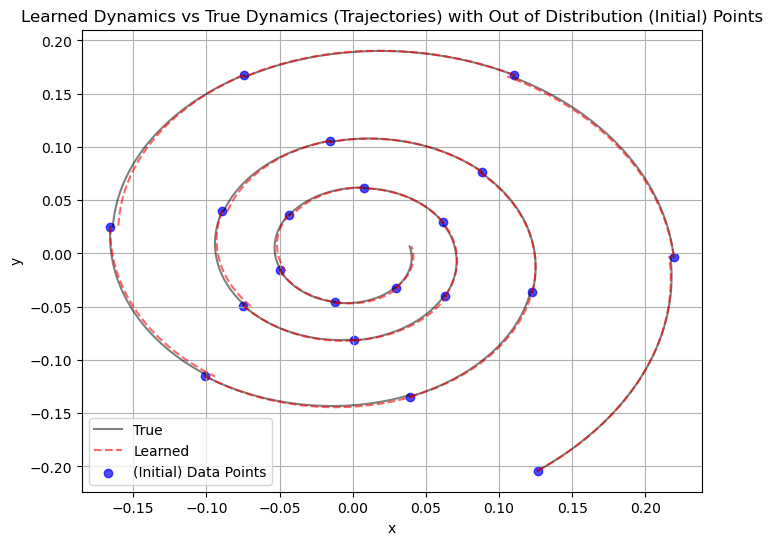

In [192]:
# Plotting
# Test fidelity out of data points

# Generate out of distribution data (always through successive realizations of the dynamics)
seed = int(time.time())
x0random = np.random.normal(0, 0.5, (1, 2))  # Another random initial point
x0s = np.zeros((Ndata,dimEx))
x1s = np.zeros((Ndata,dimEx))
x0s[0,:] = x0random
for i in range(Ndata - 1):
    x1s[i,:] = forward(# COMPLETE THE CODE
                       )
    x0s[i+1:] = # COMPLETE THE CODE
x1s[Ndata-1,:] = forward(# COMPLETE THE CODE
                         )

# Generate true trajectories
true_trajectories = np.array([odeint(linear_dynamics, x0, t_eval) for x0 in x0s])

# Generate trajectories via the learned model
learned_trajectories = np.array([
    odeint(lambda x, t: NeuralNetwork(x, flatWeights, unflatten), x0, t_eval) for x0 in x0s])

# Plot results
plt.figure(figsize=(8, 6))

# Plot the true and learned trajectories
for i in range(len(x0s)):
    plt.plot(true_trajectories[i, :, 0], true_trajectories[i, :, 1], 'k-', alpha=0.5, label="True" if i == 0 else "")
    plt.plot(learned_trajectories[i, :, 0], learned_trajectories[i, :, 1], 'r--', alpha=0.6, label="Learned" if i == 0 else "")

# Scatter plot for the initial data points (learning data points)
plt.scatter(x0s[:, 0], x0s[:, 1], color='blue', marker='o', alpha=0.7, label="(Initial) Data Points")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Learned Dynamics vs True Dynamics (Trajectories) with Out of Distribution (Initial) Points")
plt.legend()
plt.grid()
plt.show()